In [1]:
import numpy as np
from matplotlib import pyplot as plt

In [2]:
from models import PowerSource, PowerLoad, PowerBus, PowerGrid

Параметры графиков.

In [3]:
user_figsize = (12, 3*4)
user_fontsize = 14

In [4]:
seed = 1991
rng = np.random.default_rng(seed)

# Bus.
Ubus_nom = 48.0
Ubus_init = 0.95*Ubus_nom
beta_bus = 0.01e-3/(6*6*1800e-6) # dt/C

# Sources.
N_SOURCE = 5
Uinit_min, Uinit_max = [0.10*Ubus_nom, 0.95*Ubus_nom]
Rdroop_min, Rdroop_max = [2e-3, 20e-3]
beta_source_min, beta_source_max = [0.8, 0.9]

Usource_set = rng.uniform(Uinit_min, Uinit_max, size=N_SOURCE)
Rdroop_set = rng.uniform(Rdroop_min, Rdroop_max, size=N_SOURCE)
beta_source_set = rng.uniform(beta_source_min, beta_source_max, size=N_SOURCE)

# Loads.
N_LOAD = 10
Pnom_min, Pnom_max = [10.0, 8.5e3]
beta_load_min, beta_load_max = [0.1, 0.9]

Pload_set = rng.uniform(Pnom_min, Pnom_max, size=N_LOAD)
Uload_set = np.full_like(Pload_set, Ubus_nom)
beta_load_set = rng.uniform(beta_load_min, beta_load_max, size=N_LOAD)

Ptotal = np.sum(Pload_set)
print('Мощность номинальная системы электроснабжения:', Ptotal)

Мощность номинальная системы электроснабжения: 40873.710265703565


In [5]:
bus = PowerBus(Uinit=Ubus_init, beta=beta_bus)

sources = [
    PowerSource(
        Rdroop=Rdroop_set[idx],
        Uinit=Usource_set[idx],
        beta=beta_source_set[idx]
        ) for idx in range(N_SOURCE)
]

loads = [
    PowerLoad(
        Unom=Uload_set[idx],
        beta=beta_load_set[idx]
        ) for idx in range(N_LOAD)
]

In [6]:
N_STEPS = 200

source_currents = np.zeros((N_STEPS, N_SOURCE))
load_currents = np.zeros((N_STEPS, N_LOAD))
bus_voltage = np.zeros(N_STEPS)

for n in range(N_STEPS):
    if n == 0:
        source_currents[n] = [source.step(u=Ubus_init, Uref=Ubus_nom)
                           for source in sources]
        load_currents[n] = [load.step(u=Ubus_init, P=Pload_set[idx])
                           for idx, load in enumerate(loads)]
    else:
        source_currents[n] = [source.step(u=bus_voltage[n-1], Uref=Ubus_nom)
                           for source in sources]
        load_currents[n] = [load.step(u=bus_voltage[n-1], P=Pload_set[idx])
                           for idx, load in enumerate(loads)]
    bus_voltage[n] = bus.step(source_currents[n].sum() - load_currents[n].sum())
        

# Сеть целиком

In [7]:
microgrid = PowerGrid(
    Ubus_init = Ubus_init,
    beta_bus = beta_bus,
    N_SOURCE = N_SOURCE,
    Rdroop_set = Rdroop_set,
    Usource_set = Usource_set,
    beta_source_set = beta_source_set,
    N_LOAD = N_LOAD,
    Uload_set = Uload_set,
    beta_load_set = beta_load_set
)

In [8]:
Vbus, Is, Il, _, _, _ = microgrid.step(N_STEPS=N_STEPS, Uref_set=np.full_like(Usource_set, Ubus_nom), Pload_set=Pload_set)

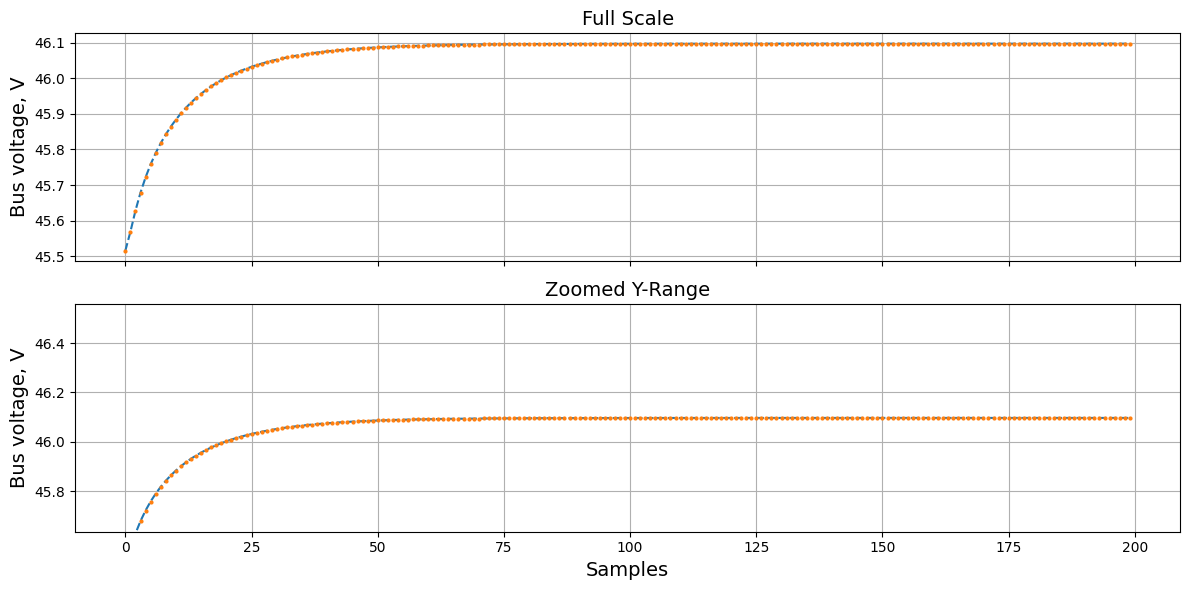

In [9]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

# Full-scale plot
ax1.plot(bus_voltage, '--')
ax1.plot(Vbus, 'o', markersize=2, linestyle='')
ax1.set_ylabel('Bus voltage, V', fontsize=user_fontsize)
ax1.set_title('Full Scale', fontsize=user_fontsize)
ax1.grid(True)

# Zoomed y-range plot
ax2.plot(bus_voltage, '--')
ax2.plot(Vbus, 'o', markersize=2, linestyle='')
ax2.set_xlabel('Samples', fontsize=user_fontsize)
ax2.set_ylabel('Bus voltage, V', fontsize=user_fontsize)
ax2.set_title('Zoomed Y-Range', fontsize=user_fontsize)
ax2.grid(True)

# Set narrow y-limits (adjust ymin and ymax based on your data!)
ymin, ymax = Vbus[-1]*0.99, Vbus[-1]*1.01
ax2.set_ylim(ymin, ymax)

plt.tight_layout()
plt.show()

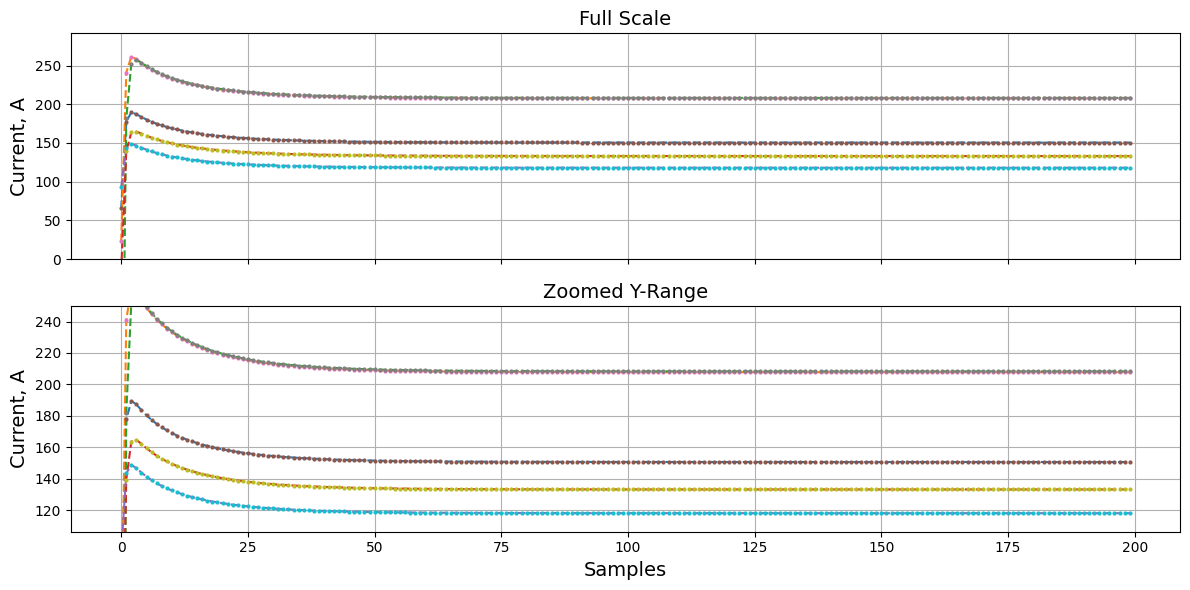

In [10]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

# Full-scale plot
ax1.plot(source_currents, '--')
ax1.plot(Is, 'o', markersize=2, linestyle='')
ax1.set_ylabel('Current, A', fontsize=user_fontsize)
ax1.set_title('Full Scale', fontsize=user_fontsize)
ax1.grid(True)
ax1.set_ylim(bottom=0)

# Zoomed y-range plot
ax2.plot(source_currents, '--')
ax2.plot(Is, 'o', markersize=2, linestyle='')
ax2.set_xlabel('Samples', fontsize=user_fontsize)
ax2.set_ylabel('Current, A', fontsize=user_fontsize)
ax2.set_title('Zoomed Y-Range', fontsize=user_fontsize)
ax2.grid(True)

# Set narrow y-limits (adjust ymin and ymax based on your data!)
ymin, ymax = Is[-1].min()*0.9, Is[-1].max()*1.2
ax2.set_ylim(ymin, ymax)

plt.tight_layout()
plt.show()

In [11]:
N_TRAIN = 10
seed_generator = rng.integers(0, 2**32, size=N_TRAIN, dtype=np.uint32)


In [12]:
bus_voltage = []
for m in range(N_TRAIN):
    load_random = np.random.default_rng(seed_generator[m])
    Pload_set = load_random.uniform(Pnom_min, Pnom_max, size=N_LOAD)
    print('Мощность системы электроснабжения:', np.sum(Pload_set))
    beta_load_set = load_random.uniform(beta_load_min, beta_load_max, size=N_LOAD)
    bv, _, _, a, _, _ = microgrid.step(N_STEPS=N_STEPS, Uref_set=np.full_like(Usource_set, Ubus_nom), Pload_set=Pload_set)
    print(a)
    bus_voltage.extend(bv)


Мощность системы электроснабжения: 38006.47415413938
46.225335283813315
Мощность системы электроснабжения: 31745.45277450559
46.50860202207022
Мощность системы электроснабжения: 49926.28537558114
45.69547710606913
Мощность системы электроснабжения: 49902.320765722674
45.69652961932442
Мощность системы электроснабжения: 44834.564989382896
45.92031982422745
Мощность системы электроснабжения: 42181.87136463603
46.03833817763762
Мощность системы электроснабжения: 30869.422519447966
46.548513173738506
Мощность системы электроснабжения: 40743.09148463531
46.102603747862354
Мощность системы электроснабжения: 36040.61174567158
46.31390432627881
Мощность системы электроснабжения: 51921.3598351977
45.60797649747391


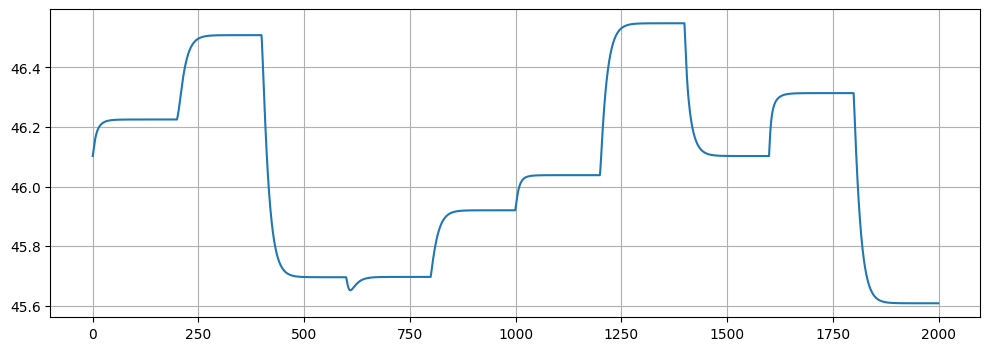

In [13]:
plt.figure(figsize=(12,4))
plt.plot(bus_voltage)
plt.grid()
plt.show()